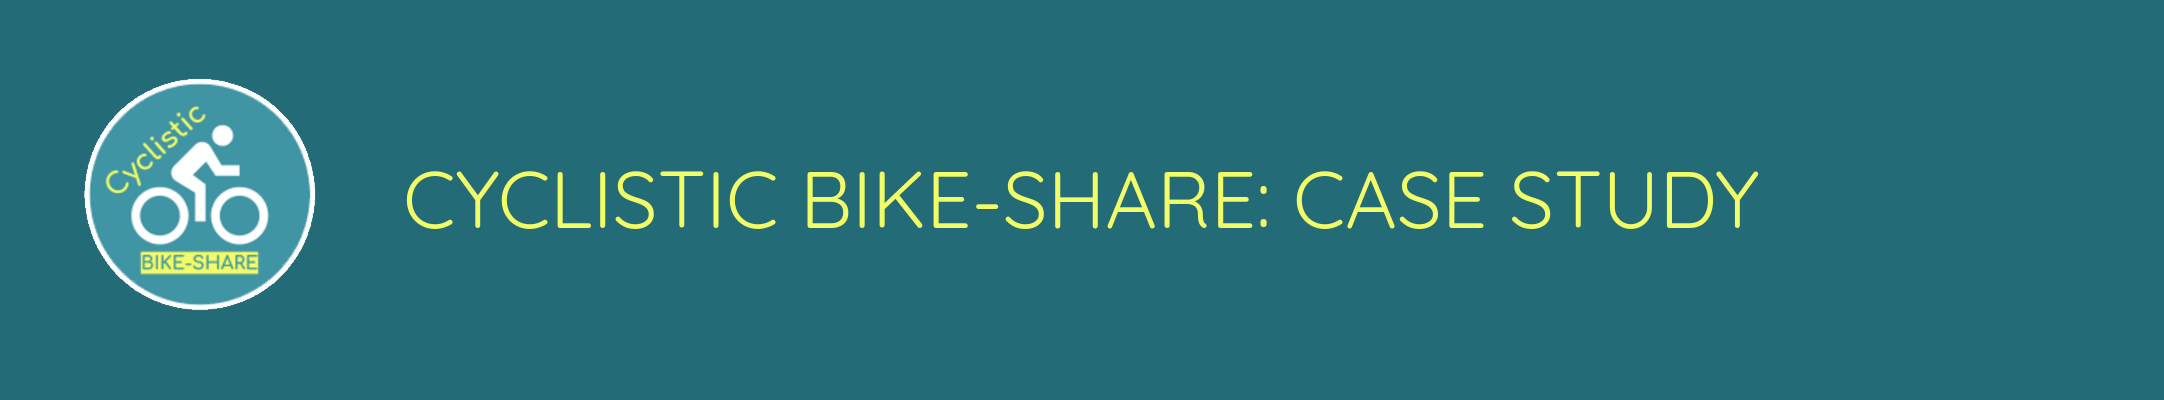

# Introduction

This notebook is part of the Capstone Case Study Project for Google's Data Analytics Certificate course. It utilizes the capabilities of R and Google Colab to streamline the data analysis workflow from start to finish.

## Scenario

In this hypothetical scenario, I am a junior data analyst working with the marketing analyst team at Cyclistic, a bike-share company in Chicago. Lily Moreno, the director of marketing, believes that the company's future success hinges on maximizing the number of annual memberships. To achieve this, my team will analyze the differences in how annual members and casual non-members use Cyclistic bikes. These insights will inform a new marketing strategy aimed at converting casual riders into annual members. However, before implementing the strategy, Cyclistic executives must approve the recommendations, which requires compelling data insights and professional data visualizations. I contend that the data will demonstrate annual members and casual non-members have distinct consumer profiles that should necessitate a distinct marketing strategy.

# Prepare

I will use Cyclistic’s historical data to analyze and identify trends from May 2023 to April 2024, which can be downloaded [here](https://divvy-tripdata.s3.amazonaws.com/index.html). This data is provided by Motivate International Inc and is public, as outlined in the [license agreement](https://divvybikes.com/data-license-agreement). While the data allows us to explore how different customer types use Cyclistic bikes, it prohibits the use of personally identifiable information. This means I cannot connect past purchases to credit card numbers to determine if casual riders live in the Cyclistic service area or if they have purchased multiple single passes. Nevertheless, this anonymized data can offer valuable insights into the behavior and profiles of non-members.

## Download Divvy Datasets
To download the files into this notebook, please run cell below:

In [1]:
# Define the base URL and the extraction path
base_url <- "https://divvy-tripdata.s3.amazonaws.com/"
extract_base_path <- "extracted_files/"

# Define the months and years to download
months <- sprintf("%02d", 5:12) # May to December 2023
months <- c(months, sprintf("%02d", 1:4)) # January to April 2024
years <- c(rep(2023, length(5:12)), rep(2024, length(1:4)))

# Loop through each month and year to download and extract files
for (i in seq_along(months)) {
  month <- months[i]
  year <- years[i]
  url <- paste0(base_url, year, month, "-divvy-tripdata.zip")
  destfile <- paste0(year, month, "-divvy-tripdata.zip")
  extract_to <- paste0(extract_base_path, year, month)

  download.file(url, destfile)
  unzip(destfile, exdir = extract_to)
  file.remove(destfile)
}

## Combine the 12 CSVs

The next step is to combine all 12 CSV files into one data frame and CSV file.

In [2]:
# Function to install packages if not already installed
install_if_missing <- function(package) {
  if (!requireNamespace(package, quietly = TRUE)) {
    install.packages(package)
  }
}

# Install and load necessary packages
install_if_missing("dplyr")
install_if_missing("readr")
library(dplyr)
library(readr)

# Define the base path for the extracted files
extract_base_path <- "/content/extracted_files/"

# Define the months and years to create file paths dynamically
months <- sprintf("%02d", 5:12) # May to December 2023
months <- c(months, sprintf("%02d", 1:4)) # January to April 2024
years <- c(rep(2023, length(5:12)), rep(2024, length(1:4)))

# Generate file paths dynamically
file_paths <- sapply(seq_along(months), function(i) {
  paste0(extract_base_path, years[i], months[i], "/", years[i], months[i], "-divvy-tripdata.csv")
})

# Combine all CSV files into one data frame
combined_data <- file_paths %>%
  lapply(read_csv) %>%
  bind_rows()

# Write the combined data to a new CSV file
write_csv(combined_data, "combined_divvy_tripdata.csv")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Rows: 604827 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (7): ride_id, rideable_type, start_station_name, start_station_id, end_...
dbl  (4): start_lat, start_lng, end_lat, end_lng
dttm (2): started_at, ended_at

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 719618 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (7): ride_id, rideable_type, start_station_name, start_station_id, end_...
dbl  (4): start_lat, start_lng, end_lat, end_lng
dttm (2): started_at, ended_at

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify

## A Glance

Having made a superficial glance at the data and combined it into one location, it's time to take another look, this time with a wider perspective. First, let's take a glimpse:

In [3]:
glimpse(combined_data)

Rows: 5,738,612
Columns: 13
$ ride_id            <chr> "0D9FA920C3062031", "92485E5FB5888ACD", "FB144B3FC8…
$ rideable_type      <chr> "electric_bike", "electric_bike", "electric_bike", …
$ started_at         <dttm> 2023-05-07 19:53:48, 2023-05-06 18:54:08, 2023-05-…
$ ended_at           <dttm> 2023-05-07 19:58:32, 2023-05-06 19:03:35, 2023-05-…
$ start_station_name <chr> "Southport Ave & Belmont Ave", "Southport Ave & Bel…
$ start_station_id   <chr> "13229", "13229", "13162", "13196", "TA1308000047",…
$ end_station_name   <chr> NA, NA, NA, "Damen Ave & Cortland St", "Southport A…
$ end_station_id     <chr> NA, NA, NA, "13133", "13229", "TA1306000029", "1343…
$ start_lat          <dbl> 41.93941, 41.93948, 41.85379, 41.89456, 41.95708, 4…
$ start_lng          <dbl> -87.66383, -87.66385, -87.64672, -87.65345, -87.664…
$ end_lat            <dbl> 41.93000, 41.94000, 41.86000, 41.91598, 41.93948, 4…
$ end_lng            <dbl> -87.65000, -87.69000, -87.65000, -87.67733, -87.663…
$ member_cas

We can see thirteen columns with their expected data types. Our main business focus will be on the member_casual column and how it relates to the other columns. Now that we have a good grasp on the basic data structure, let's move the processing phase.

# Process

Having prepared the data, it is now time to process it. This entails:
1. **Checking for Inconsistencies**: Identifying and correcting any data anomalies.
2. **Removing False Entries**: Filtering out invalid or irrelevant data entries.
3. **Adding New Columns**: Creating additional columns to facilitate the next steps of analysis.

### 1. Remove Duplicates

Removing duplicates is essential for maintaining data integrity, improving data quality, enhancing computational efficiency, ensuring analysis accuracy, and promoting consistency in data-driven decision-making processes. The following chunk will identify and remove any duplicates:

In [4]:
# Install and load the data.table package
install_if_missing("data.table")
library(data.table)

# Load the combined data
cleaned_data <- read.csv("combined_divvy_tripdata.csv")

# Convert cleaned_data to data.table
cleaned_data_dt <- as.data.table(cleaned_data)

# Check for duplicate rows
duplicate_rows <- duplicated(cleaned_data_dt)
num_duplicates_found <- sum(duplicate_rows)
cat("Number of duplicate rows found:", num_duplicates_found, "\n")

# Remove duplicates
cleaned_data_no_duplicates_dt <- unique(cleaned_data_dt)

# Print the number of rows before and after removing duplicates
cat("Number of rows before removing duplicates:", nrow(cleaned_data_dt), "\n")
cat("Number of rows after removing duplicates:", nrow(cleaned_data_no_duplicates_dt), "\n")

# Optionally convert back to data.frame if needed
cleaned_data_no_duplicates <- as.data.frame(cleaned_data_no_duplicates_dt)


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last




Number of duplicate rows found: 0 
Number of rows before removing duplicates: 5738612 
Number of rows after removing duplicates: 5738612 


### 2. Assess the Nulls

A cursory glance at the dataset reveals a number of null values for station name, station id, end latitude, and end longitude.  The following code will calculate the total number of nulls, the number of nulls in each column, and create a separate data frame, which we may or may not employ depending on the results.

In [5]:
# Calculate the number of NA values for each column
na_counts <- sapply(combined_data, function(x) sum(is.na(x)))
cat("Number of NA values for each column:\n")
print(na_counts)

# Determine how many rows are impacted by null values
num_rows_with_na <- sum(!complete.cases(combined_data))

# Determine the total number of rows
total_num_rows <- nrow(combined_data)

# Calculate the percentage of rows impacted by null values
percent_rows_with_na <- (num_rows_with_na / total_num_rows) * 100

# Print the results
cat("Number of rows impacted by null values:", num_rows_with_na, "\n")
cat("Total number of rows in the dataset:", total_num_rows, "\n")
cat("Percentage of rows impacted by null values:", round(percent_rows_with_na, 2), "%\n")

# Create a separate data frame of rows with null values for reference
rows_with_na <- combined_data[!complete.cases(combined_data), ]

# Retain rows with null values and only ignore them when necessary in analysis
cleaned_data <- combined_data

Number of NA values for each column:
           ride_id      rideable_type         started_at           ended_at 
                 0                  0                  0                  0 
start_station_name   start_station_id   end_station_name     end_station_id 
            885429             885429             939115             939115 
         start_lat          start_lng            end_lat            end_lng 
                 0                  0               7610               7610 
     member_casual 
                 0 
Number of rows impacted by null values: 1402773 
Total number of rows in the dataset: 5738612 
Percentage of rows impacted by null values: 24.44 %


With over a million rows containing null values, their removal during the cleaning stage could significantly impact the analysis. Therefore, instead of removing these rows entirely, I have chosen to retain them during the cleaning process and deal with them only when they pose a problem.

### 3. Check for Consistent ride_id Formatting

A brief glance at the `ride_id` shows a consistent format of 16 unique characters. I would assume that any entry that does not have this consistent formatting to be a typographical error. However, given the extent of the dataset, it would be inefficient to manually confirm whether or not each `ride_id` conforms to the formatting. Therefore, I have included this line of code to identify any inconsistency.

In [6]:
# Check if ride_id has consistent formatting of 16 characters
inconsistent_ride_ids <- subset(cleaned_data, nchar(as.character(ride_id)) != 16)

# Print any inconsistent ride_id entries
if (nrow(inconsistent_ride_ids) > 0) {
  cat("Inconsistent ride_id formatting found:\n")
  print(inconsistent_ride_ids)
} else {
  cat("No inconsistent ride_id formatting found.\n")
}

No inconsistent ride_id formatting found.


### 4. Create New Columns

At this point, I want to create some new columns to aid in the ease of analysis later on in the process. The `started_at` column contains more than one data point. To improve ease of analysis, I will be creating three new columns: `day_of_week`, `month`, and `ride_length`.

In [7]:
# Install and load necessary libraries
install_if_missing("lubridate")
install_if_missing("dplyr")

library(lubridate)
library(dplyr)

# Convert started_at and ended_at columns to POSIXct date-time objects if they aren't already
combined_data$started_at <- as.POSIXct(combined_data$started_at, format="%Y-%m-%d %H:%M:%S")
combined_data$ended_at <- as.POSIXct(combined_data$ended_at, format="%Y-%m-%d %H:%M:%S")

# Create a new column day_of_week
combined_data$day_of_week <- lubridate::wday(combined_data$started_at, label = TRUE, abbr = FALSE)

# Add a new column 'day_type' to classify days as 'Weekday' or 'Weekend'
combined_data <- combined_data %>%
  mutate(day_type = ifelse(day_of_week %in% c("Friday", "Saturday", "Sunday"), "Weekend", "Weekday"))

# Create a new column month
combined_data$month <- lubridate::month(combined_data$started_at, label = TRUE, abbr = FALSE)

# Create a new column ride_length
combined_data$ride_length <- difftime(combined_data$ended_at, combined_data$started_at, units = "mins")

# View the first few rows to check the new columns
head(combined_data)


Attaching package: ‘lubridate’


The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,day_of_week,day_type,month,ride_length
<chr>,<chr>,<dttm>,<dttm>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<ord>,<chr>,<ord>,<drtn>
0D9FA920C3062031,electric_bike,2023-05-07 19:53:48,2023-05-07 19:58:32,Southport Ave & Belmont Ave,13229,NA,NA,41.93941,-87.66383,41.93000,-87.65000,member,Sunday,Weekend,May,4.733333 mins
92485E5FB5888ACD,electric_bike,2023-05-06 18:54:08,2023-05-06 19:03:35,Southport Ave & Belmont Ave,13229,NA,NA,41.93948,-87.66385,41.94000,-87.69000,member,Saturday,Weekend,May,9.450000 mins
FB144B3FC8300187,electric_bike,2023-05-21 00:40:21,2023-05-21 00:44:36,Halsted St & 21st St,13162,NA,NA,41.85379,-87.64672,41.86000,-87.65000,member,Sunday,Weekend,May,4.250000 mins
DDEB93BC2CE9AA77,classic_bike,2023-05-10 16:47:01,2023-05-10 16:59:52,Carpenter St & Huron St,13196,Damen Ave & Cortland St,13133,41.89456,-87.65345,41.91598,-87.67733,member,Wednesday,Weekday,May,12.850000 mins
C07B70172FC92F59,classic_bike,2023-05-09 18:30:34,2023-05-09 18:39:28,Southport Ave & Clark St,TA1308000047,Southport Ave & Belmont Ave,13229,41.95708,-87.66420,41.93948,-87.66375,member,Tuesday,Weekday,May,8.900000 mins
2BA66385DF8F815A,classic_bike,2023-05-30 15:01:21,2023-05-30 15:17:00,Clinton St & Madison St,TA1305000032,McClurg Ct & Ohio St,TA1306000029,41.88275,-87.64119,41.89259,-87.61729,member,Tuesday,Weekday,May,15.650000 mins


### 5. Remove Suspicious Ride Length Entries

Improperly logged ride length entries may negatively impact analysis. I have decided to focus on two kinds of suspicious entries: `ride_length` shorter than one minute and `ride_length` longer than 24 hours. The short ride lengths are a widely known issue with the dataset and are likely due to false starts or users trying to re-dock a bike to ensure it was secure. These rows should be removed. Any `ride_length` longer than 24 hours are likely due to a rider not properly docking their return or the return station being offline at the time of the return. These rows should also be removed.

First let's handle the short rides:

In [8]:
# Identify rides with a duration less than one minute
short_rides <- combined_data[combined_data$ride_length < 1, ]

# Count the number of such rides
num_short_rides <- nrow(short_rides)

# Print the number of short rides and the rides themselves if there are any
if (num_short_rides > 0) {
  cat("Number of rides with a duration less than one minute:", num_short_rides, "\n")
  print(short_rides)
} else {
  print("There are no rides with a duration less than one minute.")
}

# Remove rides with a duration < 1 minute
cleaned_data <- combined_data[combined_data$ride_length >= 1, ]

Number of rides with a duration less than one minute: 138466 
# A tibble: 138,466 × 17
   ride_id          rideable_type started_at          ended_at           
   <chr>            <chr>         <dttm>              <dttm>             
 1 EDFAA5BE875DC63D electric_bike 2023-05-05 11:36:02 2023-05-05 11:36:14
 2 ED43FFDBB169DB26 electric_bike 2023-05-05 11:36:35 2023-05-05 11:36:54
 3 712F509D6E15A359 classic_bike  2023-05-16 08:38:50 2023-05-16 08:39:44
 4 B5212C2EB90D6C67 electric_bike 2023-05-15 05:43:22 2023-05-15 05:44:05
 5 2DF3660451B32E41 electric_bike 2023-05-23 22:09:53 2023-05-23 22:10:40
 6 A5CC09E0277CE035 electric_bike 2023-05-15 17:18:03 2023-05-15 17:18:04
 7 DF065F1E9FC7C567 electric_bike 2023-05-30 03:11:56 2023-05-30 03:11:59
 8 A5B6B11BB48E64F8 electric_bike 2023-05-23 09:39:57 2023-05-23 09:40:13
 9 1AB175B0DEF6C932 electric_bike 2023-05-04 16:56:40 2023-05-04 16:56:59
10 ABC4C2B01929896D classic_bike  2023-05-10 05:22:52 2023-05-10 05:23:02
# ℹ 138,456 more rows
# ℹ

Next we'll handle the over 24 hour rides:

In [9]:
# Convert cleaned_data to data.table
cleaned_data_dt <- as.data.table(cleaned_data)

# Filter out rides longer than 24 hours (1440 minutes)
cleaned_data_dt <- cleaned_data_dt[ride_length <= 1440]

# Convert back to data.frame if needed
cleaned_data <- as.data.frame(cleaned_data_dt)

# Print the number of remaining rows
cat("Number of remaining rows after filtering:", nrow(cleaned_data), "\n")

# View the first few rows of the cleaned data frame to check the result
head(cleaned_data)

Number of remaining rows after filtering: 5592825 


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,day_of_week,day_type,month,ride_length
,<chr>,<chr>,<dttm>,<dttm>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<ord>,<chr>,<ord>,<drtn>
1,0D9FA920C3062031,electric_bike,2023-05-07 19:53:48,2023-05-07 19:58:32,Southport Ave & Belmont Ave,13229,NA,NA,41.93941,-87.66383,41.93000,-87.65000,member,Sunday,Weekend,May,4.733333 mins
2,92485E5FB5888ACD,electric_bike,2023-05-06 18:54:08,2023-05-06 19:03:35,Southport Ave & Belmont Ave,13229,NA,NA,41.93948,-87.66385,41.94000,-87.69000,member,Saturday,Weekend,May,9.450000 mins
3,FB144B3FC8300187,electric_bike,2023-05-21 00:40:21,2023-05-21 00:44:36,Halsted St & 21st St,13162,NA,NA,41.85379,-87.64672,41.86000,-87.65000,member,Sunday,Weekend,May,4.250000 mins
4,DDEB93BC2CE9AA77,classic_bike,2023-05-10 16:47:01,2023-05-10 16:59:52,Carpenter St & Huron St,13196,Damen Ave & Cortland St,13133,41.89456,-87.65345,41.91598,-87.67733,member,Wednesday,Weekday,May,12.850000 mins
5,C07B70172FC92F59,classic_bike,2023-05-09 18:30:34,2023-05-09 18:39:28,Southport Ave & Clark St,TA1308000047,Southport Ave & Belmont Ave,13229,41.95708,-87.66420,41.93948,-87.66375,member,Tuesday,Weekday,May,8.900000 mins
6,2BA66385DF8F815A,classic_bike,2023-05-30 15:01:21,2023-05-30 15:17:00,Clinton St & Madison St,TA1305000032,McClurg Ct & Ohio St,TA1306000029,41.88275,-87.64119,41.89259,-87.61729,member,Tuesday,Weekday,May,15.650000 mins


### Save the Work

After making these transformations, it is important to save the work as a new CSV file named `cleaned_data.csv`.

In [10]:
# Define the file path for the cleaned data CSV
cleaned_data_file <- "cleaned_data.csv"

# Write the cleaned data to a new CSV file
write.csv(cleaned_data, file = cleaned_data_file, row.names = FALSE)

# Print a message indicating that the cleaned data has been saved
cat("Cleaned data has been saved to", cleaned_data_file, "\n")

Cleaned data has been saved to cleaned_data.csv 


# Analyze & Share

With our data now prepared and processed, we're ready to dive into the analysis phase. Leveraging the streamlined features of notebooks, we can seamlessly generate high-quality data visualizations alongside our analysis.

While our dataset offers a wealth of information, it's crucial to maintain a clear focus on our objective: understanding the distinctive behaviors of casual riders compared to members of Cyclistic, with the ultimate goal of encouraging casual riders to become members. Any tangential inquiries should be set aside for future exploration.

I will pose five main questions:
1.  Are casual riders really that important?
2.  Do casual riders have a bike preference?
3.  How are casual riders using their bikes?
4.  When are casual riders using their bikes?
5.  Where do casual riders most frequently ride?

## Question 1: Are Casual Riders Really That Important?

We are conducting this analysis because Lily Moreno, the director of marketing, believes that the company's future success hinges on maximizing annual memberships by reaching out to already existing customers who use our services as casual riders, but what does the data say about their importance? A good first question to ask is what percentage of the rides from our May 2023 to April 2024 data were taken by casual non-members?


Attaching package: ‘scales’


The following object is masked from ‘package:readr’:

    col_factor




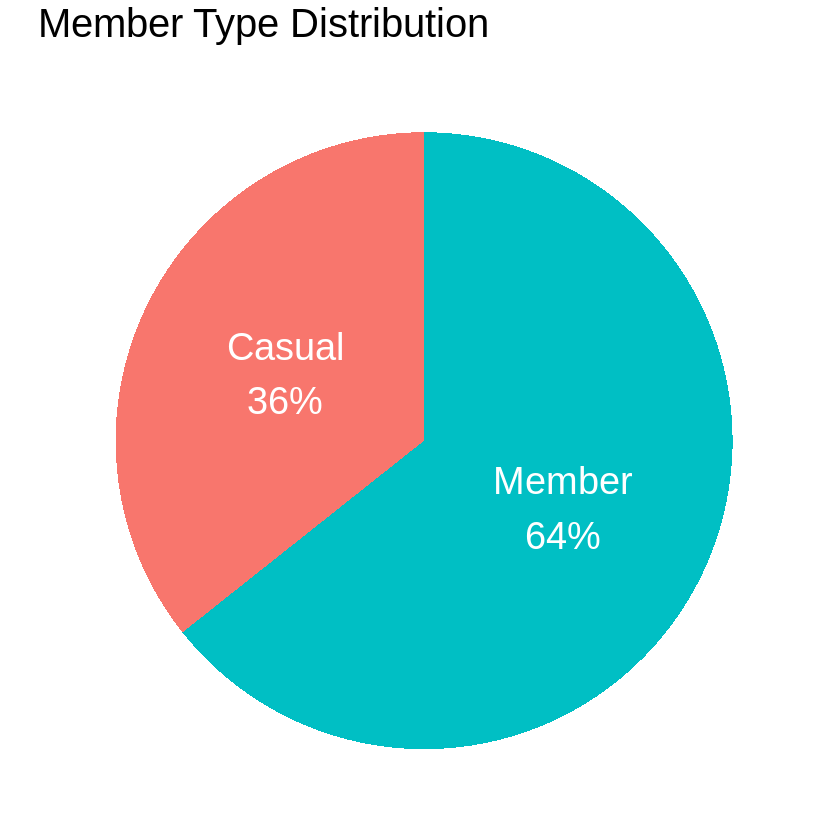

In [11]:
# Load necessary libraries
install_if_missing("ggplot2")
install_if_missing("scales")
install_if_missing("dplyr")

library(ggplot2)
library(scales)
library(dplyr)


# Update the member_casual column
cleaned_data <- cleaned_data %>%
  mutate(member_casual = recode(member_casual,
                                "member" = "Member",
                                "casual" = "Casual"))

# Recalculate the number of rides by the updated member_casual
rides_by_member <- cleaned_data %>%
  group_by(member_casual) %>%
  summarise(Number_of_Rides = n())

# Recalculate percentages
rides_by_member <- rides_by_member %>%
  mutate(Percentage = Number_of_Rides / sum(Number_of_Rides) * 100)

# Create a pie chart with percentage and category labels
ggplot(rides_by_member, aes(x = "", y = Number_of_Rides, fill = member_casual)) +
  geom_bar(width = 1, stat = "identity") +
  geom_text(aes(label = paste0(member_casual, "\n", round(Percentage), "%")),
            position = position_stack(vjust = 0.5),
            size = 8,
            color = "white") +
  coord_polar(theta = "y") +
  labs(title = "Member Type Distribution") +
  theme_minimal() +
  theme(axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        panel.grid = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks = element_blank(),
        legend.position = "none",  # Remove legend
        plot.title = element_text(size = 24))


As depicted in the pie chart above, casual riders constituted over one-third of the total bike rides throughout the year. This sizable existing base presents a significant opportunity for Cyclistic to engage with. If Moreno's assertion regarding the company's future success depending on maximizing annual memberships holds true, then understanding the profile of non-member riders becomes paramount.

## Question 2: Do Casual Riders Have a Bike Preference?

As a follow-up inquiry, let's delve into the bike preferences of casual non-members. Cyclistic offers three types of bicycles: the classic bike, the electric bike, and the docked bike, which may be in the process of being phased out. Let's examine the data to discern their preferences.

pdf 
  2

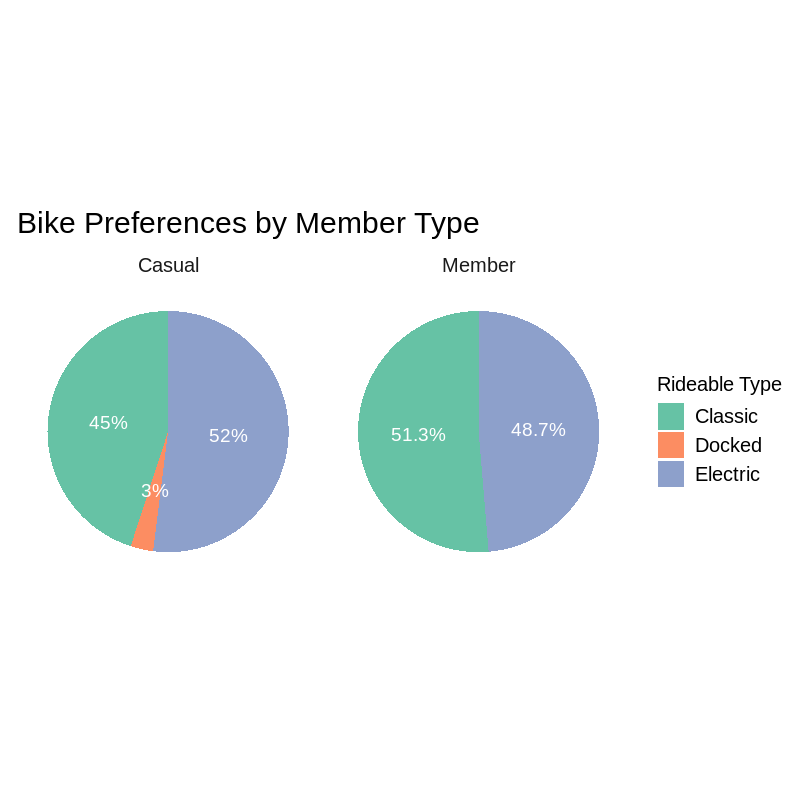

In [12]:
install_if_missing("ggplot2")
install_if_missing("dplyr")
install_if_missing("RColorBrewer")
install_if_missing("IRdisplay")

library(ggplot2)
library(dplyr)
library(RColorBrewer)
library(IRdisplay)

# Calculate the number of rides by member_casual and rideable_type
rides_by_member_casual <- cleaned_data %>%
  group_by(member_casual, rideable_type) %>%
  summarise(Number_of_Rides = n(), .groups = 'drop')

# Calculate percentages
rides_by_member_casual <- rides_by_member_casual %>%
  group_by(member_casual) %>%
  mutate(percentage = Number_of_Rides / sum(Number_of_Rides) * 100, .groups = 'drop')

# Define custom labels for rideable types
rideable_labels <- c(
  classic_bike = "Classic",
  docked_bike = "Docked",
  electric_bike = "Electric"
)

# Plot pie charts using facet_wrap
plot <- ggplot(rides_by_member_casual, aes(x = "", y = percentage, fill = rideable_type)) +
  geom_bar(stat = "identity", width = 1) +
  coord_polar(theta = "y") +
  facet_wrap(~ member_casual, labeller = labeller(member_casual = c("member" = "Member", "casual" = "Casual"))) +
  labs(title = "Bike Preferences by Member Type",
       x = NULL, y = NULL) +  # Removed subtitle
  theme_minimal() +
  theme(axis.text.x = element_blank(),
        axis.ticks = element_blank(),
        panel.grid = element_blank(),
        strip.text = element_text(size = 12),
        plot.title = element_text(size = 18),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 12),
        strip.placement = "outside") +
  scale_fill_brewer(palette = "Set2", name = "Rideable Type", labels = rideable_labels) +
  geom_text(aes(label = paste0(round(percentage, 1), "%")),
            position = position_stack(vjust = 0.5),
            color = "white", size = 4)

# Save the plot as a PNG file
png("Bike_Preferences_Member_Type.png", width = 800, height = 800, res = 120)
print(plot)
dev.off()

# Display the saved PNG file
display_png(file = "Bike_Preferences_Member_Type.png")

As illustrated in the two side-by-side pie charts, the preferences of members and non-members reveal subtle distinctions. While the majority of members favored classic bikes, casual non-members showed a slightly higher inclination towards electric bikes. Interestingly, some non-members still expressed a preference for the older docked bikes, potentially indicative of phased-out models. Gathering such insights is crucial for constructing a data-driven profile of casual non-member riders

## Question 3: How Are Casual Riders Using Our Bikes?

Understanding the non-member profile is critical to reaching them with membership opportunities. How do they prefer to use Cyclistic's services? Are they popping on a bike for a quick ride from A to B or are they enjoying longer, more leisurely rides? Are they riding solo or in a group? When do they ride the most? Let's see what the data has to say about how they behaved over the past year.

### Casual Riders: Lone Wolves or Wolf Pack?

While we cannot be entirely certain from the available data whether a group of friends or a family rented bikes together, the data can provide some insights. The following code identifies clusters of people checking out bikes from the same location within a three-minute window and returning them to the same location. If these criteria are met, we infer that it was likely a group trip. Let's explore what the data suggests:

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# A tibble: 2 × 3
  member_casual total_groups avg_group_size
  <chr>                <int>          <dbl>
1 Casual              194681           2.20
2 Member              130525           2.20


pdf 
  2

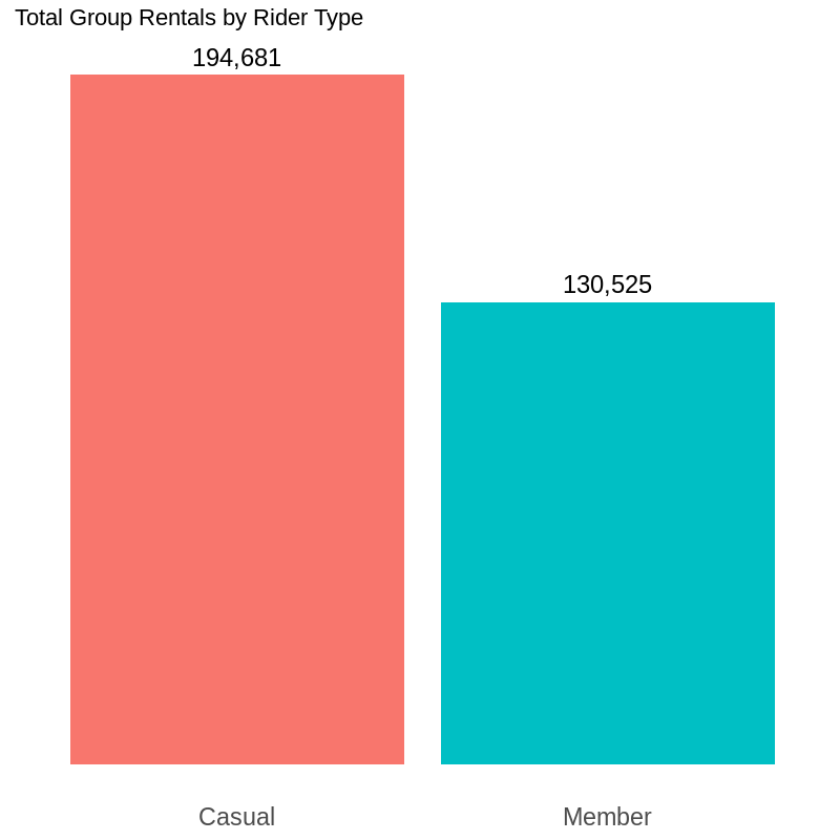

In [13]:
install_if_missing("png")

library(ggplot2)
library(scales)
library(dplyr)
library(lubridate)


# Define your time window in minutes
time_window <- 3

# Convert ride_length to numeric if it's not already
cleaned_data$ride_length <- as.numeric(gsub(" mins", "", cleaned_data$ride_length))

# Identify potential group rentals with member type
potential_groups <- cleaned_data %>%
  mutate(
    start_time_group = floor_date(started_at, unit = "5 minutes"),
    end_time_group = floor_date(ended_at, unit = "5 minutes")
  ) %>%
  group_by(start_station_id, end_station_id, start_time_group, end_time_group, member_casual) %>%
  filter(n() > 1) %>%  # More than one bike rented within the same time and place
  summarise(group_size = n(), .groups = 'drop')

# Summarize group rentals by member type
group_summary <- potential_groups %>%
  group_by(member_casual) %>%
  summarise(total_groups = n(), avg_group_size = mean(group_size))

# View summary of potential group rentals
print(group_summary)

# Create the bar chart and assign it to a variable
plot <- ggplot(group_summary, aes(x = member_casual, y = total_groups, fill = member_casual)) +
  geom_bar(stat = "identity") +
  labs(
    title = "Total Group Rentals by Rider Type",
    x = NULL,  # Remove X axis title
    y = NULL   # Remove Y axis title
  ) +
  theme_minimal() +
  theme(
    legend.position = "none",
    panel.grid.major = element_blank(),  # Remove major gridlines
    panel.grid.minor = element_blank(),  # Remove minor gridlines
    axis.text.y = element_blank(),       # Remove Y axis numbers
    axis.text.x = element_text(size = 14)  # Increase font size of X axis categories
    # No specific title size set, uses default
  ) +
  geom_text(aes(label = comma(total_groups)), vjust = -0.5, size = 5)  # Add values over each bar with commas

# Save the plot as a PNG file
png("Total_Group_Rentals_by_Rider_Type.png", width = 800, height = 800, res = 120)
print(plot)
dev.off()

# Display the saved PNG file
library(png)
library(grid)

img <- readPNG("Total_Group_Rentals_by_Rider_Type.png")
grid.raster(img)

The chart above clearly demonstrates that, although casual riders make up only 36% of Cyclistic's riders, they are far more likely to travel in groups compared to members. This data point adds an intriguing detail to the emerging profile of casual riders.

### How Long Are Riders Renting?

The duration of bike rentals can provide insights into rider behavior. Are they in a rush to get from point A to point B? Are they taking their time in a more leisurely fashion? Do we see any noticeable differences between members and casual riders?

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



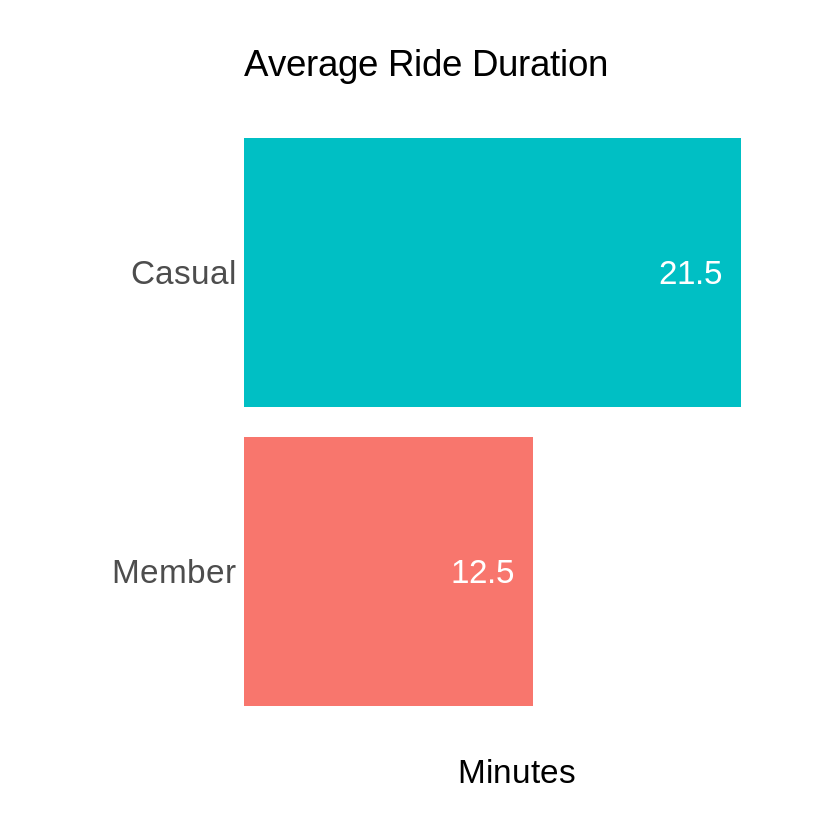

In [14]:
install_if_missing("patchwork")

library(ggplot2)
library(scales)

# Ensure ride_length is in numeric format (in minutes)
cleaned_data$ride_length <- as.numeric(difftime(cleaned_data$ended_at, cleaned_data$started_at, units = "mins"))

# Calculate the average ride length
average_ride_length <- mean(cleaned_data$ride_length, na.rm = TRUE)

# Aggregate average ride length by member type
average_ride_length_by_member <- aggregate(ride_length ~ member_casual, data = cleaned_data, mean)

# Reorder the levels of member_casual factor
average_ride_length_by_member$member_casual <- factor(average_ride_length_by_member$member_casual, levels = c("Member", "Casual"))

# Create the horizontal bar plot for average ride length
ggplot(average_ride_length_by_member, aes(x = member_casual, y = ride_length, fill = member_casual)) +
  geom_col() +
  labs(
    title = "Average Ride Duration",
    y = "Minutes",
    x = ""
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 22),
    axis.text.x = element_blank(),  # Remove x-axis numbers
    axis.title.x = element_text(size = 20),
    axis.text.y = element_text(size = 20),
    axis.title.y = element_text(size = 20, margin = margin(r = 20)),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    plot.margin = margin(30, 30, 30, 30, "pt")
  ) +
  scale_y_continuous(labels = comma, expand = c(0, 0), limits = c(NA, max(average_ride_length_by_member$ride_length) * 1.1)) +
  guides(fill = "none") +
  geom_text(aes(label = comma(round(ride_length, 2))), hjust = 1.3, size = 7, color = "white") +
  coord_flip()


As we delve deeper into understanding casual riders, a clearer picture begins to emerge. Despite their less frequent usage of the bike service, casual riders are spending more time on the roads compared to typical annual members. This discrepancy suggests that casual riders may have different motivations for using Cyclistic bikes than annual members. Based solely on the data mentioned earlier, I hypothesize that annual members are utilizing Cyclistic services more for business-related purposes rather than leisure. If this conjecture holds true, it will likely become evident when we examine how the data is distributed throughout the week. Let's explore further.

## Question 4: When Are Casual Riders Using Our Bikes?

### Days of the Week

The rhythms of the city align with the weekly cycle. If my hypothesis is correct, it should be evident when examining the data by day of the week. Business-minded members are likely to have a greater presence on weekdays, while leisure-oriented casual riders may show increased activity on weekends. Let's take a look:

pdf 
  2

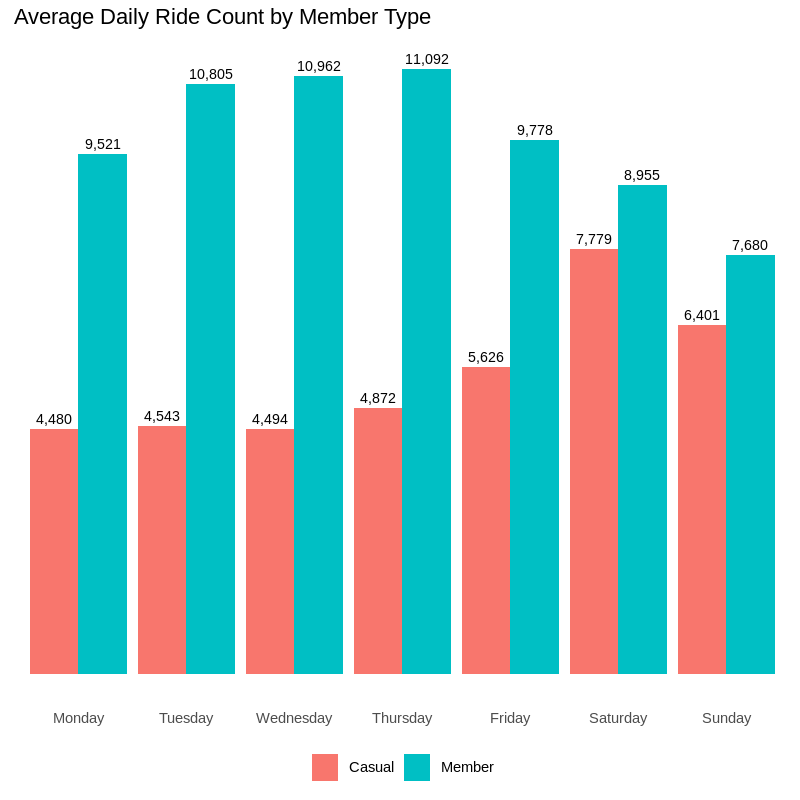

In [15]:
# Load necessary libraries
library(ggplot2)
library(data.table)
library(lubridate)
library(IRdisplay)
library(scales)  # For formatting numbers with commas

# Convert cleaned_data to data.table if not already done
cleaned_data_dt <- as.data.table(cleaned_data)

# Extract the day of the week from the started_at column
cleaned_data_dt[, day_of_week := wday(started_at, label = TRUE, abbr = FALSE)]

# Group by day of the week, member type, and date, and count rides
rides_by_day_member <- cleaned_data_dt[, .N, by = .(member_casual, day_of_week, date = as.Date(started_at))]

# Calculate the average number of rides per day of the week for each member type
average_rides_by_day_member <- rides_by_day_member[, .(average_rides_per_day = mean(N)), by = .(member_casual, day_of_week)]

# Reorder the levels of day_of_week so that Monday appears first
average_rides_by_day_member$day_of_week <- factor(average_rides_by_day_member$day_of_week,
                                                  levels = c("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"))

# Plot the data
plot <- ggplot(average_rides_by_day_member, aes(x = day_of_week, y = average_rides_per_day, fill = member_casual)) +
  geom_bar(stat = "identity", position = "dodge") +
  geom_text(aes(label = comma(round(average_rides_per_day))),  # Format with commas
            position = position_dodge(width = 0.9), vjust = -0.5, hjust = 0.5, size = 3, color = "black") +
  labs(title = "Average Daily Ride Count by Member Type",
       x = NULL,  # Remove x-axis title
       y = NULL) +  # Remove y-axis title
  scale_x_discrete(labels = c("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday")) +
  theme_minimal() +
  theme(panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.text.y = element_blank(),
        legend.position = "bottom",
        legend.title = element_blank())  # Remove legend title

# Save the plot as a PNG file
png("Average_Daily_Ride_Count_By_Member_Type.png", width = 800, height = 800, res = 120)
print(plot)
dev.off()

# Display the saved PNG file
display_png(file = "Average_Daily_Ride_Count_By_Member_Type.png")


The above chart is supportive of the hypothesis that members and non-members utilize Cyclistic services for distinct purposes. The data indicates that members predominantly utilize Cyclistic bikes on weekdays, whereas non-members primarily engage with the service during the weekend.

### Hours of the Day

This comprehensive analysis paints a vivid picture, yet let's quickly verify an unexplored assumption. If members indeed utilize Cyclistic services for business purposes and non-members for leisure, we should anticipate a sharp increase in member usage at the onset of the typical workday. Let's delve into the data to confirm this hypothesis.

pdf 
  2

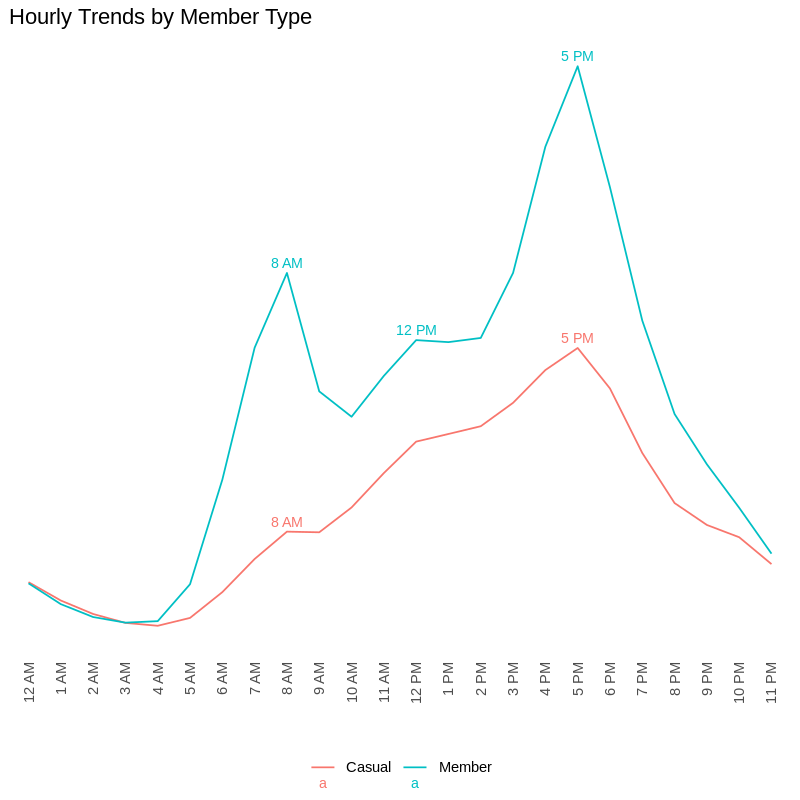

In [16]:
# Ensure the necessary libraries are loaded
library(ggplot2)
library(dplyr)

# Convert started_at to a POSIXct date-time object if not already done
cleaned_data$started_at <- as.POSIXct(cleaned_data$started_at, format = "%Y-%m-%d %H:%M:%S")

# Extract hour in AM/PM format without leading zeros
cleaned_data$hour_AMPM <- format(cleaned_data$started_at, "%-I %p")

# Convert hour_AMPM to an ordered factor to ensure chronological ordering
cleaned_data$hour_AMPM <- factor(cleaned_data$hour_AMPM, levels = c(
  "12 AM", "1 AM", "2 AM", "3 AM", "4 AM", "5 AM", "6 AM", "7 AM", "8 AM", "9 AM", "10 AM", "11 AM",
  "12 PM", "1 PM", "2 PM", "3 PM", "4 PM", "5 PM", "6 PM", "7 PM", "8 PM", "9 PM", "10 PM", "11 PM"
), ordered = TRUE)

# Aggregate data for annotations
agg_data <- cleaned_data %>%
  group_by(hour_AMPM, member_casual) %>%
  summarise(count = n(), .groups = 'drop')

# Identify local maxima
agg_data <- agg_data %>%
  group_by(member_casual) %>%
  mutate(is_peak = (count > lag(count, default = first(count)) & count > lead(count, default = last(count))))

# Filter to only include peaks
peak_data <- agg_data %>% filter(is_peak)

# Visualization: Hourly Trends by Member Type (Line Graph)
plot <- ggplot(agg_data, aes(x = hour_AMPM, y = count, color = member_casual, group = member_casual)) +
  geom_line() +
  geom_text(data = peak_data, aes(label = hour_AMPM), vjust = -0.5, size = 3) +  # Annotate peak hours
  labs(title = "Hourly Trends by Member Type",
       x = "",
       y = NULL) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),
    axis.text.y = element_blank(),
    legend.position = "bottom",
    legend.title = element_blank(),
    panel.grid = element_blank()
  ) +
  scale_color_manual(values = c("#F8766D", "#00BFC4")) +
  scale_y_continuous(breaks = NULL)

# Save the plot as a PNG file
png("Hourly_Trends_By_Member_Type.png", width = 800, height = 800, res = 120)
print(plot)
dev.off()

# Display the saved PNG file
display_png(file = "Hourly_Trends_By_Member_Type.png")


As anticipated, members exhibited a notable surge in usage during the onset of the standard workday hours. This observation aligns with the hypothesis that non-members do not simply represent individuals without membership passes; rather, they constitute a distinct consumer demographic characterized by unique preferences and behavioral patterns.

### The Seasons

Given our hypothesis that casual non-members are more motivated by leisure and experiential factors rather than utilitarian business concerns, it's crucial to ascertain the seasonality of their preferences. By identifying the periods during which non-members are most inclined to ride, we can better tailor our strategies for future campaigns and promotions.

pdf 
  2

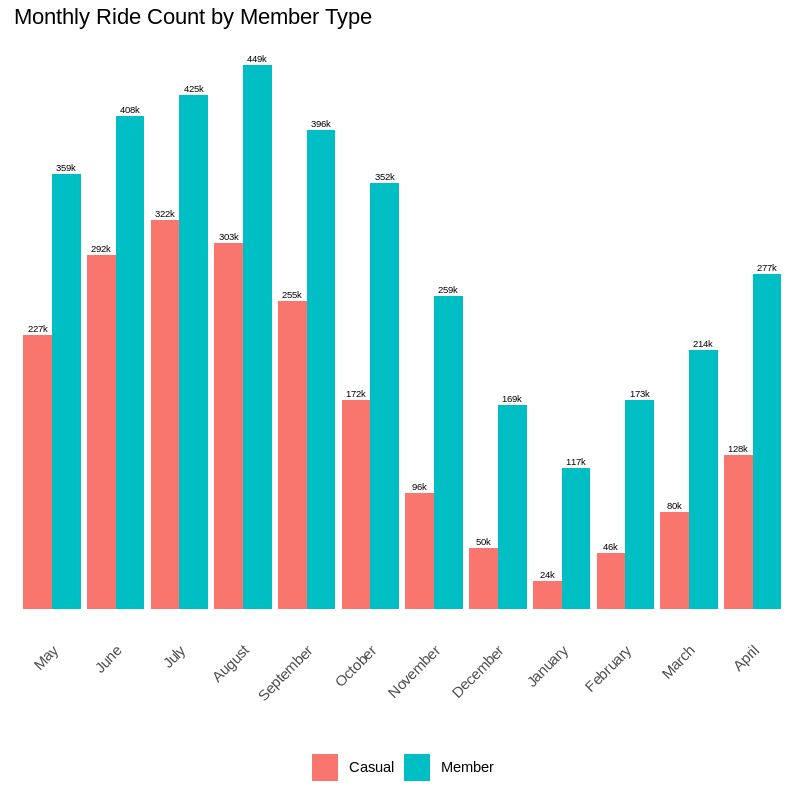

In [17]:
# Load necessary libraries
library(ggplot2)
library(lubridate)
library(scales)  # For formatting the y-axis labels

# Calculate the number of rides by month and member type
rides_by_month_member <- table(cleaned_data$month, cleaned_data$member_casual)

# Convert the result to a data frame for plotting purposes
rides_by_month_member_df <- as.data.frame(rides_by_month_member)
colnames(rides_by_month_member_df) <- c("month", "member_casual", "Number_of_Rides")

# Define the correct order of months
correct_order <- c("May", "June", "July", "August", "September", "October", "November", "December",
                   "January", "February", "March", "April")

# Ensure month names are factors with the correct order
rides_by_month_member_df$month <- factor(rides_by_month_member_df$month, levels = correct_order)

# Custom label function to format numbers with "k"
label_with_k <- function(x) {
  ifelse(x >= 1000, paste0(round(x / 1000), "k"), as.character(x))
}

# Create a standard bar plot
plot <- ggplot(rides_by_month_member_df, aes(x = month, y = Number_of_Rides, fill = member_casual)) +
  geom_bar(stat = "identity", position = "dodge") +  # Change position to "dodge"
  geom_text(aes(label = label_with_k(Number_of_Rides)),
            position = position_dodge(width = 0.9),
            color = "black",  # Change text color to black
            size = 2,
            vjust = -0.5) +  # Position text above the bars
  labs(title = "Monthly Ride Count by Member Type",
       x = "",
       y = NULL) +  # Remove y-axis title
  scale_y_continuous(labels = NULL) +  # Remove y-axis numbers
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1),
        panel.grid.major = element_blank(),  # Remove major grid lines
        panel.grid.minor = element_blank(),  # Remove minor grid lines
        legend.position = "bottom",          # Move legend to the bottom
        legend.title = element_blank())      # Remove legend title

# Save the plot as a PNG file
png("Monthly_Ride_Count_By_Member_Type.png", width = 800, height = 800, res = 120)
print(plot)
dev.off()

# Display the saved PNG file
display_png(file = "Monthly_Ride_Count_By_Member_Type.png")


We observe a subtle distinction between members and non-members, with both groups showing relatively similar patterns in ride counts across the months. However, recognizing May through September as the busiest months provides valuable insight that will prove beneficial in future strategies.

As we delve deeper into the data, a distinct profile of the non-member begins to emerge: they epitomize the 'weekend warrior,' utilizing Cyclistic services primarily for leisure rather than professional obligations. This understanding serves as a cornerstone for crafting targeted campaigns aimed at engaging the non-member demographic. Fortunately, our dataset offers ample opportunity for further refinement in delineating the characteristics of non-member riders.

## Question 5: Where Are Casual Members Using Our Bikes?

The Divvy Data License Agreement strictly prohibits any attempt to correlate the data with identifiable information such as names or addresses of customers or members. However, we can gain a general understanding of where members and non-members tend to pick up and drop off their bikes. It's important to exercise caution and avoid making unwarranted assumptions based solely on this data.

Consider this scenario: Tom, a resident of the Rodgers Park neighborhood in Chicago, plans to meet his friend John, who is visiting from out of town. They decide to visit the Shedd Aquarium in the South Loop. After parking in an all-day garage, they rent bikes to explore downtown, returning them near a popular restaurant for lunch. Subsequently, they rent another pair of bikes and ride back to the parking garage area. From the data alone, we can only discern a fraction of this story. It would be incorrect to assume that the start location necessarily indicates one's neighborhood or that it represents the beginning of a journey; John, like Tom's friend, might not even be a resident of Chicago.

To mitigate such assumptions, it's best to interpret our GPS data in terms of "stomping grounds" or "cycling grounds." For our next analysis, we aim to explore whether these cycling grounds differ between members and non-members. To accomplish this, I'll identify the top ten locations for both groups and discern if they collectively form distinct patterns resembling favored areas for bike usage.

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rbibutils’, ‘Deriv’, ‘microbenchmark’, ‘Rdpack’, ‘numDeriv’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘reformulas’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘Formula’, ‘pbkrtest’, ‘quantreg’, ‘lme4’, ‘corrplot’, ‘car’, ‘ggrepel’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘gridExtra’, ‘polynom’, ‘rstatix’




pdf 
  2

pdf 
  2

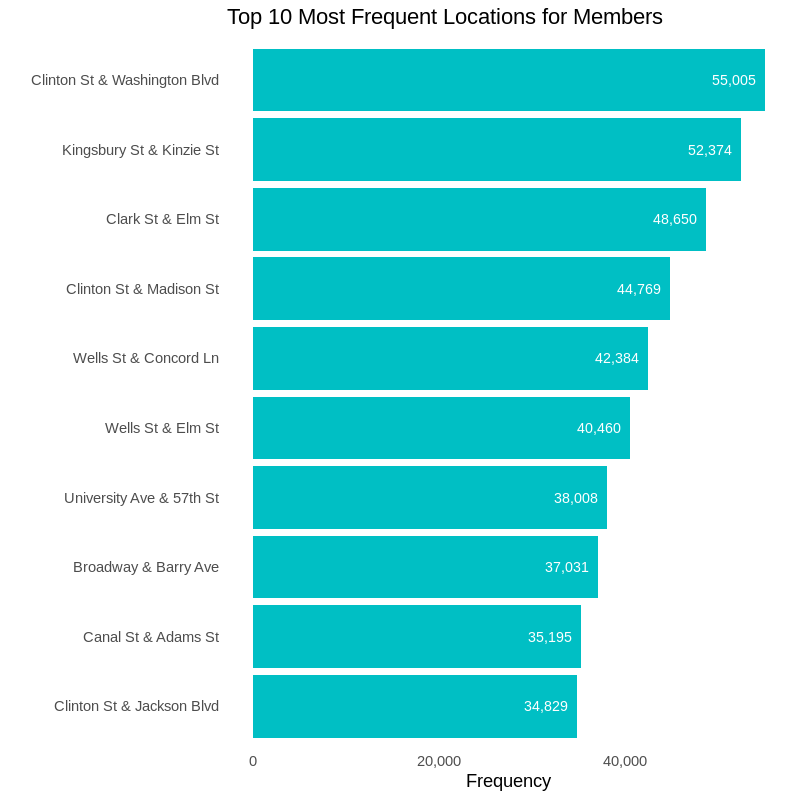

In [18]:
install_if_missing("ggpubr")

# Load necessary libraries
library(dplyr)
library(ggplot2)
library(tidyr)
library(scales)


gps_df <- read.csv("cleaned_data.csv")

# Combine the start and end station names into a single column
combined_stations <- gps_df %>%
  select(member_casual, start_station_name, end_station_name) %>%
  gather(key = "station_type", value = "station_name", -member_casual) %>%
  filter(!is.na(station_name)) # Remove rows with NA station names

# Calculate the frequency of each station for members
member_station_freq <- combined_stations %>%
  filter(member_casual == "member") %>%
  count(station_name, sort = TRUE) %>%
  top_n(10, n)

# Calculate the frequency of each station for casual users
casual_station_freq <- combined_stations %>%
  filter(member_casual == "casual") %>%
  count(station_name, sort = TRUE) %>%
  top_n(10, n)

# Plot for members
graph1 <- ggplot(member_station_freq, aes(x = n, y = reorder(station_name, n))) +
  geom_col(fill = "#00BFC4") +  # Set the color of the bars
  geom_text(aes(label = comma(n)), hjust = 1.2, size = 3, color = "white") +  # Add text labels inside the bars with commas
  labs(title = "Top 10 Most Frequent Locations for Members",
       x = "Frequency",
       y = "") +
  scale_x_continuous(labels = comma) +  # Format x-axis labels with commas
  theme_minimal() +
  theme(axis.text.y = element_text(angle = 0, hjust = 1),
        panel.grid.major = element_blank(),  # Remove major grid lines
        panel.grid.minor = element_blank())  # Remove minor grid lines

# Plot for casual users
graph2 <- ggplot(casual_station_freq, aes(x = n, y = reorder(station_name, n))) +
  geom_col(fill = "#F8766D") +  # Set the color of the bars
  geom_text(aes(label = comma(n)), hjust = 1.2, size = 3, color = "white") +  # Add text labels inside the bars with commas
  labs(title = "Top 10 Most Frequent Locations for Casual Riders",
       x = "Frequency",
       y = "") +
  scale_x_continuous(labels = comma) +  # Format x-axis labels with commas
  theme_minimal() +
  theme(axis.text.y = element_text(angle = 0, hjust = 1),
        panel.grid.major = element_blank(),  # Remove major grid lines
        panel.grid.minor = element_blank())  # Remove minor grid lines

# Save the plot as a PNG file
png("Top_10_Most_Frequented_Locations_For_Members.png", width = 800, height = 800, res = 120)
print(graph1)
dev.off()

# Save the plot as a PNG file
png("Top_10_Most_Frequented_Locations_For_Casuals.png", width = 800, height = 800, res = 120)
print(graph2)
dev.off()

# Display the saved PNG file
display_png(file = "Top_10_Most_Frequented_Locations_For_Members.png")

Now let's look at casual non-members:

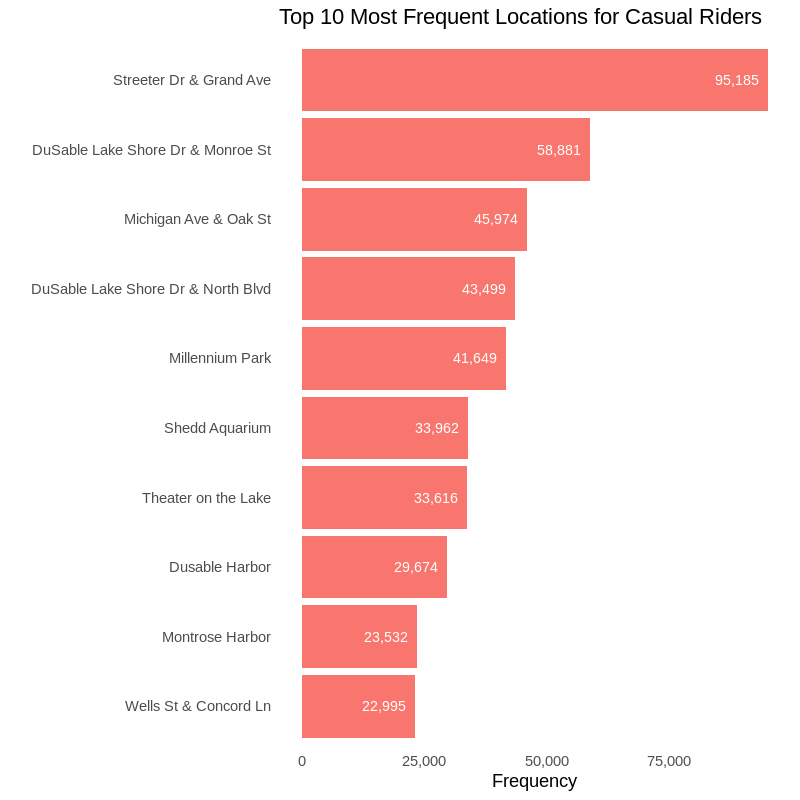

In [19]:
display_png(file = "Top_10_Most_Frequented_Locations_For_Casuals.png")

Now, even someone unfamiliar with Chicago can discern that members and non-members exhibit distinct patterns in their choice of pick-up and drop-off locations. To further explore this spatial aspect of the data, let's delve into visualizations that depict these patterns geographically.

pdf 
  2

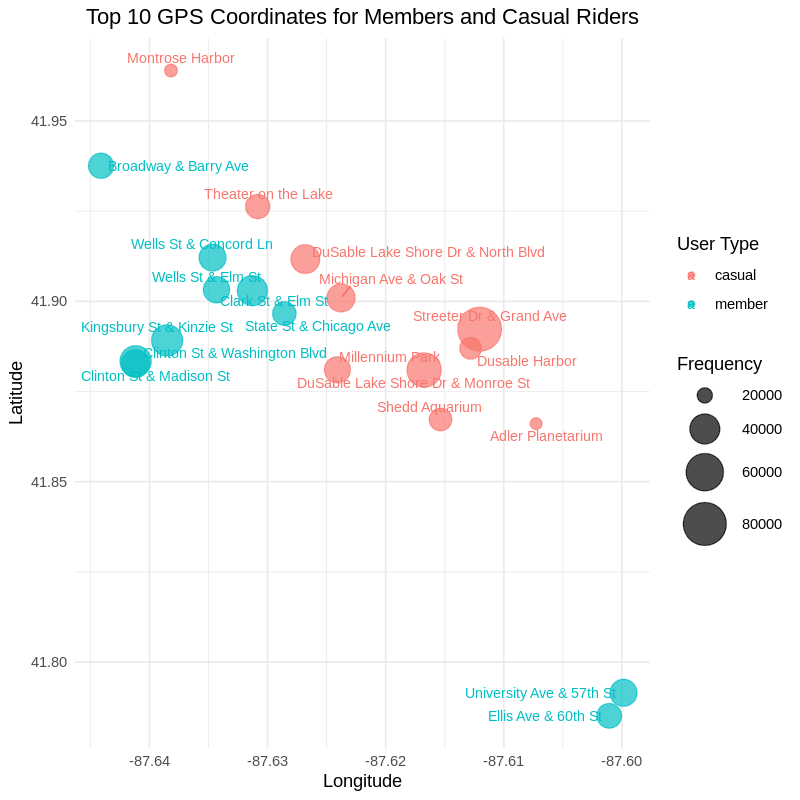

In [20]:
library(dplyr)
library(ggplot2)
library(ggrepel)

# Combine start and end coordinates into a single data frame with counts and station names
all_coordinates <- gps_df %>%
  select(member_casual, start_station_name, start_lat, start_lng) %>%
  rename(station_name = start_station_name, lat = start_lat, lng = start_lng) %>%
  bind_rows(
    gps_df %>%
      select(member_casual, end_station_name, end_lat, end_lng) %>%
      rename(station_name = end_station_name, lat = end_lat, lng = end_lng)
  ) %>%
  filter(!is.na(lat) & !is.na(lng) & !is.na(station_name))  # Remove rows with NA coordinates or station names

# Count occurrences of each coordinate
coordinate_counts <- all_coordinates %>%
  group_by(member_casual, lat, lng, station_name) %>%
  summarise(count = n(), .groups = 'drop')

# Get top 10 most frequent coordinates for members and casual users
top_10_members <- coordinate_counts %>%
  filter(member_casual == "member") %>%
  arrange(desc(count)) %>%
  head(10)

top_10_casuals <- coordinate_counts %>%
  filter(member_casual == "casual") %>%
  arrange(desc(count)) %>%
  head(10)

# Combine the top 10 for both groups
top_10_combined <- bind_rows(top_10_members, top_10_casuals)

# Plot for both members and casual users with point size based on count and station names as text labels using ggrepel
combined_plot <- ggplot(top_10_combined, aes(x = lng, y = lat, color = member_casual, size = count, label = station_name)) +
  geom_point(alpha = 0.7) +  # Moderate transparency
  scale_size_continuous(range = c(3, 12)) +  # Larger range for point sizes
  geom_text_repel(size = 3) +  # Add text labels for station names using ggrepel
  labs(title = "Top 10 GPS Coordinates for Members and Casual Riders",
       x = "Longitude",
       y = "Latitude",
       color = "User Type",
       size = "Frequency") +
  theme_minimal() +
  scale_color_manual(values = c("member" = "#00BFC4", "casual" = "#F8766D")) +
  theme(plot.title = element_text(hjust = 0.5))

# Save the plot as a PNG file
png("Top_10_GPS_Coordinates.png", width = 800, height = 800, res = 120)
print(combined_plot)
dev.off()

# Display the saved PNG file
display_png(file = "Top_10_GPS_Coordinates.png")

The plotted data provides clear evidence that both members and non-members tend to frequent distinct areas, supporting our earlier hypotheses. Let's delve into the observations for each group:

**Observations for Members:**

1. **Clustered Business District:** Locations such as Clinton St & Washington Blvd, Clinton St & Madison St, Clinton St & Jackson Blvd, and Canal St & Adams St, all featured in the top ten locations for member riders. These sites are concentrated in the downtown business district. This aligns well with our earlier observation of increased member activity during typical work hours. Moreover, this area is surrounded by transit hubs, including train and bus stations, suggesting that riders may utilize other transportation modes, resulting in shorter ride durations.

2. **Residential Proximity:** Locations like Broadway & Barry Ave and University Ave & 57th St are situated near densely populated residential neighborhoods.

3. **University Proximity:** University Ave & 57th St, located near the University of Chicago, likely sees significant student engagement, indicating that students are making effective use of their memberships.

4. **Recreational Proximity:** Sites such as Wells St & Concord Ln and Wells St & Elm St are close to major recreational and leisure areas, suggesting that members are not solely focused on work but also have leisure activities, like visiting Lincoln Park.

**Observations for Non-Members:**

The locations favored by non-members predominantly coincide with popular tourist or recreational destinations. For instance, Streeter Dr & Grand Ave is in proximity to Navy Pier, while DuSable Lake Shore Dr. & Monroe St is near Grant Park, Millennium Park, and the Art Institute of Chicago. Similarly, Michigan Ave & Oak St is adjacent to the downtown shopping district. These areas house renowned attractions such as Millennium Park, Shedd Aquarium, Theater on the Lake, DuSable Harbor, and Montrose Harbor. This observation reinforces our understanding of non-members as pleasure-seekers who enjoy weekend rides to leisurely destinations, preferably using electric bikes.

# Act

Our analysis highlights a significant difference in consumer behavior between casual riders (non-members) and annual members. Members primarily use Cyclistic services for business purposes, while casual non-members are motivated by leisure and exploration. This fundamental divergence underscores the need for tailored marketing strategies to convert casual non-members into annual members.

# Recommendations

1. **A Qualitative Survey:** Conduct an in-depth qualitative survey to refine the casual non-member profile into a fully developed persona. I recommend setting up five in-depth interviews to better understand and tailor offerings to this consumer segment.

2.  **A Qualitative Survey:** Implement a quantitative survey on the Cyclistic website, offering a chance at a discounted rate or swag. This will ensure that our qualitative insights are scalable.

3. **Emotional Appeal in Marketing:** If survey results support the original argument, marketing efforts should prioritize emotional and sensory appeals over logical messaging. The conversion message should evoke joy and adventure, emphasizing year-round fun. Use imagery featuring scenic locations from the "Top 10 Most Frequent Locations for Casual Riders" graph to effectively convey this message.

4. **Strategic Promotions:** Time promotional activities to coincide with peak seasons. By targeting the busy season, Cyclistic can capitalize on heightened interest and engagement among potential members.
---

These recommendations aim to leverage insights into consumer behavior to drive effective marketing strategies and foster the conversion of casual non-members into loyal annual members.